In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import alphalens
import warnings
warnings.filterwarnings('ignore')

In [2]:
position= pd.read_csv('持仓.csv')
basic = pd.read_csv('基本信息.csv')
nav = pd.read_csv('净值.csv')
business_day= pd.read_csv('偏股混合型基金指数.csv') #辅助输入交易日序列
stock_industry=pd.read_csv('行业历史映射.csv')

In [3]:
#输出需要的交易日序列
business_day['date']=business_day['date'].astype('datetime64[ns]')
business1=pd.DataFrame(business_day['date'])  #辅助输入交易日序
business2=business1[(business1['date']>='2016-01-01')&(business1['date']<='2022-12-31')]

In [4]:
#筛选出主动偏股型基金
basic=basic[(basic['是否初始基金']==1)&(basic['status_o']==101001000)&(basic['grading_flg']=='非分级基金')] #筛选出初始基金、未停盘、非分级基金
basic1=basic[basic['investtype2'].isin(['普通股票型基金','偏股混合型基金'])]#筛选出主动偏股型公募基金
basic2=basic1[basic1['setupdate']<'2021-01-01']
fund=basic2[['fund_code']]
fund_list=fund['fund_code'].tolist()

In [5]:
#筛选主动股票基金的净值和行业
nav_1=nav.rename(columns={'sid':'fund_code'})
nav_2=nav_1[['date','fund_code','adjnav']]
adjnav= pd.merge(fund,nav_2,how='inner',on='fund_code')  #筛选主动股票基金的净值和行业
adjnav.drop_duplicates(subset=['date','fund_code'],keep='first',inplace=True)
adjnav_11=adjnav.reset_index().set_index(['date','fund_code']).unstack()['adjnav']

adjnav_final=pd.DataFrame(adjnav_11.columns.values)
adjnav_final.columns=['fund_code'] 
adjnav_list=adjnav_final['fund_code'].values

In [6]:
#半年底和年底的全市场股票行业映射
stock_industry_1=stock_industry
stock_industry['date'] = pd.to_datetime(stock_industry['date'])

stock_industry_2=stock_industry_1
times=pd.date_range('2009-12-31',periods=27,freq='6M')
stock_industry=pd.DataFrame()

for i in range(1,len(times)):
    stock_industry_3=stock_industry_2[(stock_industry_2['date']>times[i-1])&(stock_industry_2['date']<=times[i])]
    stock_industry_4=stock_industry_3.drop_duplicates(subset=['sid'],keep='last')
    stock_industry_4['date']=times[i]
    stock_industry=pd.concat([stock_industry,stock_industry_4])

stock_industry=stock_industry[['date','sid','industry']]

In [7]:
#半年底和年底的主动偏股型基金持仓股票行业映射
position['date'] = pd.to_datetime(position['date'])
position_stock_industry=pd.DataFrame()

for time in times:
    stock_industry_time=stock_industry[stock_industry['date']==time]
    position_time=position[position['date']==time] 
    position_1 =position_time[['fund_code','sid','stock_ratio']]
    
    position_2=position_1.merge(stock_industry_time,how='left',on='sid')
    position_3=position_2[['date','fund_code','sid','stock_ratio','industry']]

    position_stock_industry=pd.concat([position_stock_industry,position_3])

list=['date','fund_code','sid','stock_ratio','industry']
position_stock_industry=position_stock_industry[list]

In [8]:
#position_stock_industry['industry'].fillna('其他', inplace=True)
position_stock_industry_1=\
position_stock_industry[position_stock_industry['fund_code'].isin(adjnav_list)] #保留下fund_list的基金
position_stock_industry_1.drop_duplicates(subset=['date','fund_code'],keep='first',inplace=True)
position_stock_industry_2=position_stock_industry_1.set_index(['date','fund_code']).unstack()['industry']    #去重后剩2545只基金

In [9]:
#半年底和年底的全市场股票行业映射
stock_industry_1=stock_industry
stock_industry['date'] = pd.to_datetime(stock_industry['date'])

stock_industry_2=stock_industry_1
times=pd.date_range('2009-12-31',periods=27,freq='6M')
stock_industry=pd.DataFrame()

for i in range(1,len(times)):
    stock_industry_3=stock_industry_2[(stock_industry_2['date']>times[i-1])&(stock_industry_2['date']<=times[i])]
    stock_industry_4=stock_industry_3.drop_duplicates(subset=['sid'],keep='last')
    stock_industry_4['date']=times[i]
    stock_industry=pd.concat([stock_industry,stock_industry_4])

stock_industry=stock_industry[['date','sid','industry']]

In [10]:
#输出主动偏股型基金第一重仓行业
stock_ratio_sum_1=position_stock_industry_1.groupby(['date','fund_code','industry']).sum('stock_ratio') 
stock_ratio_sum=stock_ratio_sum_1.reset_index()
stock_ratio_max_1=stock_ratio_sum.sort_values(by=['date','fund_code','stock_ratio'],ascending=[True,True,False]).\
groupby(['date','fund_code']).head(1)

industry_2022=stock_ratio_max_1[stock_ratio_max_1['date']=='2022-12-31']  #最新一期报告期的行业基金池数量对比
industry_2022_1=industry_2022.groupby('industry').count()
industry_2022_1=industry_2022_1.sort_values(by='fund_code',ascending=False)

In [11]:
#adjnav_list是最终确定的基金
stock_ratio_sum_2=stock_ratio_sum.set_index(['date','fund_code'])['industry'].unstack()
final_list=stock_ratio_sum_2.columns.values
position_stock_industry_4=position_stock_industry_2.stack().reset_index()
position_stock_industry_5=position_stock_industry_4[position_stock_industry_4['fund_code'].isin(adjnav_list)]  

In [12]:
position_stock_industry_5.columns=['date','fund_code','industry']
position_stock_industry_6=position_stock_industry_5.set_index(['date','fund_code']).unstack()['industry']  #行业分布
target_industry='医药生物'                          #############################################修改行业
position_stock_industry_7=position_stock_industry_6==target_industry  #输出行业True的框架

In [13]:
######输出行业True的框架（日度）
position_stock_industry_8=position_stock_industry_7.resample('D').ffill()   #把半年的赋值给日度的
position_stock_industry_9=position_stock_industry_8.reset_index()
position_stock_industry_10=pd.merge(position_stock_industry_9,business2,how='inner',on='date')
position_stock_industry_11=position_stock_industry_10.set_index('date')

In [14]:
#把净值表变成规定形状
adjnav_12=adjnav_11.stack().reset_index()
adjnav_12.columns=['date','fund_code','adjnav']
adjnav_13=adjnav_12[adjnav_12['fund_code'].isin(adjnav_list)]
adjnav_14=adjnav_13.set_index(['date','fund_code']).unstack()['adjnav']

adjnav_15=adjnav_14.reset_index()
adjnav_15['date']=adjnav_15['date'].astype('datetime64[ns]')
adjnav_16=pd.merge(adjnav_15,business2,how='inner',on='date')
adjnav_17=adjnav_16.set_index('date')
adjnav_18=adjnav_17[position_stock_industry_11]  #把净值套在行业True的框架里

In [15]:
######################################################################################构造factor表
max_month=adjnav_18.resample('M').max()  #输出每个月净值的max
t=12
max_month_pct=(max_month-max_month.rolling(t).mean())/max_month.rolling(t).mean()
#max_month_pct=max_month.pct_change()  #构造胜利因子
max_day=max_month_pct.resample('D').ffill()
max_day=max_day.replace(0,np.nan)
max_day_1=max_day.reset_index()
max_day_1['date']=max_day_1['date'].astype('datetime64[ns]')
max_day_2=pd.merge(max_day_1,business2,how='inner',on='date')
max_day_3=max_day_2.set_index('date')
factor=max_day_3.stack()

In [16]:
######################################################################################构造price表
business3=business2[business2['date']>='2016-02-01']
price=adjnav_18.reset_index()
price_1=pd.merge(price,business3,how='inner',on='date')
price_final=price_1.set_index('date')

Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.340182,0.362524,-0.032882,0.143139,2864,6.483599
2,-0.313268,0.385154,-0.017683,0.149537,2167,4.905712
3,-0.263134,0.410541,0.018181,0.157928,2182,4.939669
4,-0.260631,0.426464,0.011972,0.151973,2282,5.166052
5,-0.251834,0.447598,0.018583,0.167036,2029,4.593304
6,-0.234972,0.459361,0.042261,0.148487,2050,4.640844
7,-0.230908,0.461805,0.036192,0.161042,2206,4.994001
8,-0.227757,0.470197,0.054873,0.162682,2251,5.095873
9,-0.222649,0.473128,0.041683,0.165911,1948,4.409934


Returns Analysis


,1D
Ann. alpha,0.100
beta,0.331
Mean Period Wise Return Top Quantile (bps),8.942
Mean Period Wise Return Bottom Quantile (bps),5.845
Mean Period Wise Spread (bps),3.097


<Figure size 640x480 with 0 Axes>

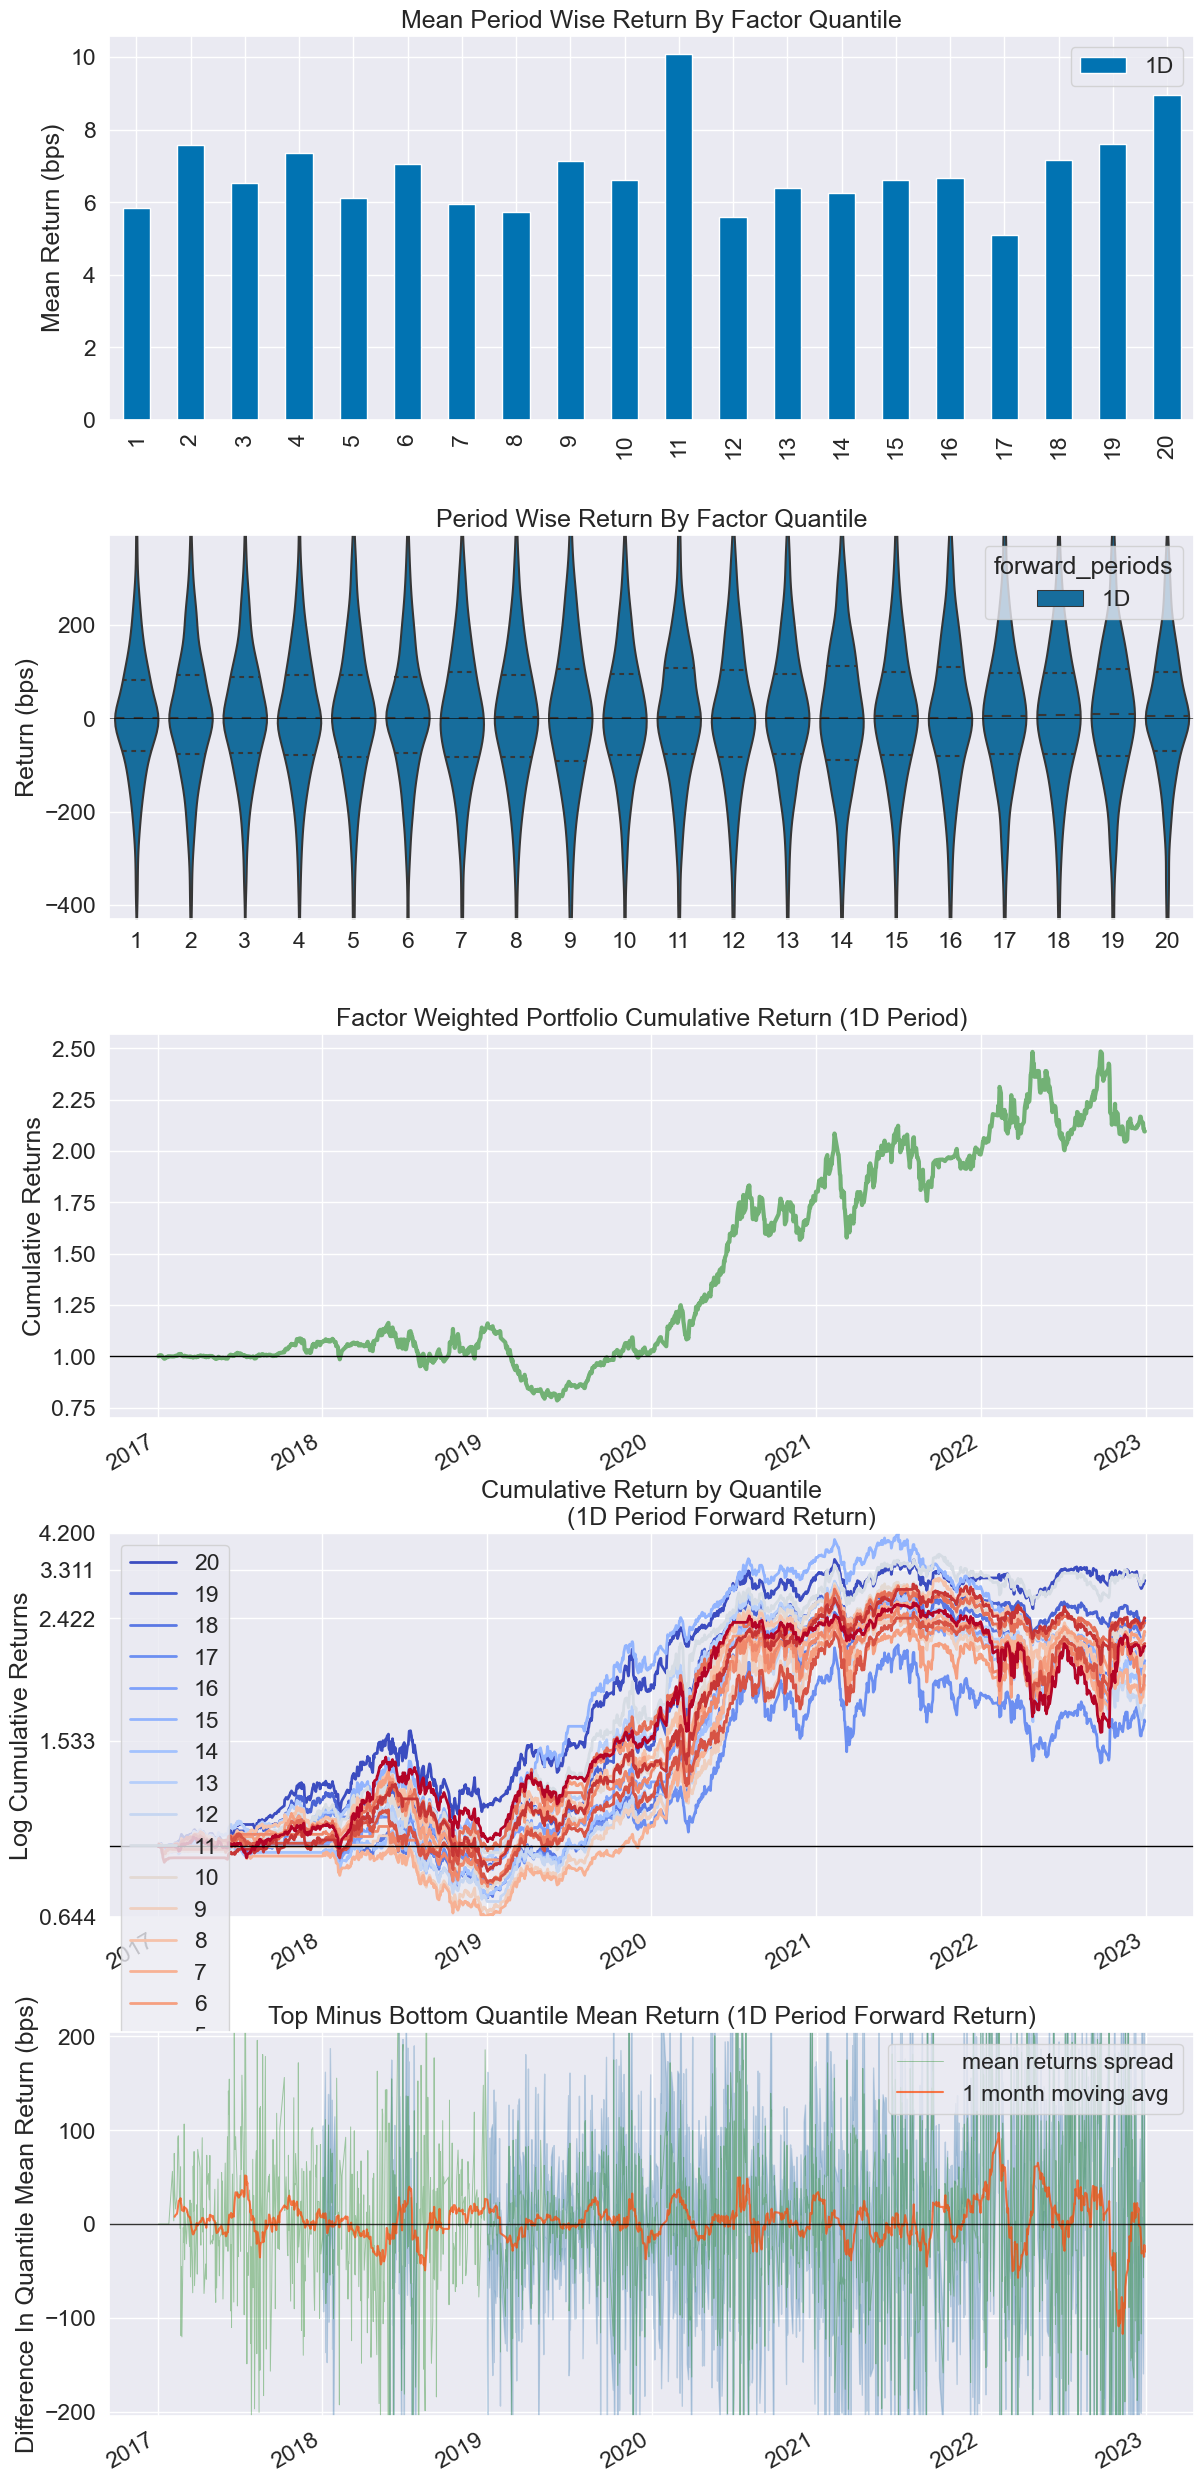

Information Analysis


,1D
IC Mean,0.020
IC Std.,0.302
Risk-Adjusted IC,0.065
t-stat(IC),2.482
p-value(IC),0.013
IC Skew,-0.059
IC Kurtosis,-0.322


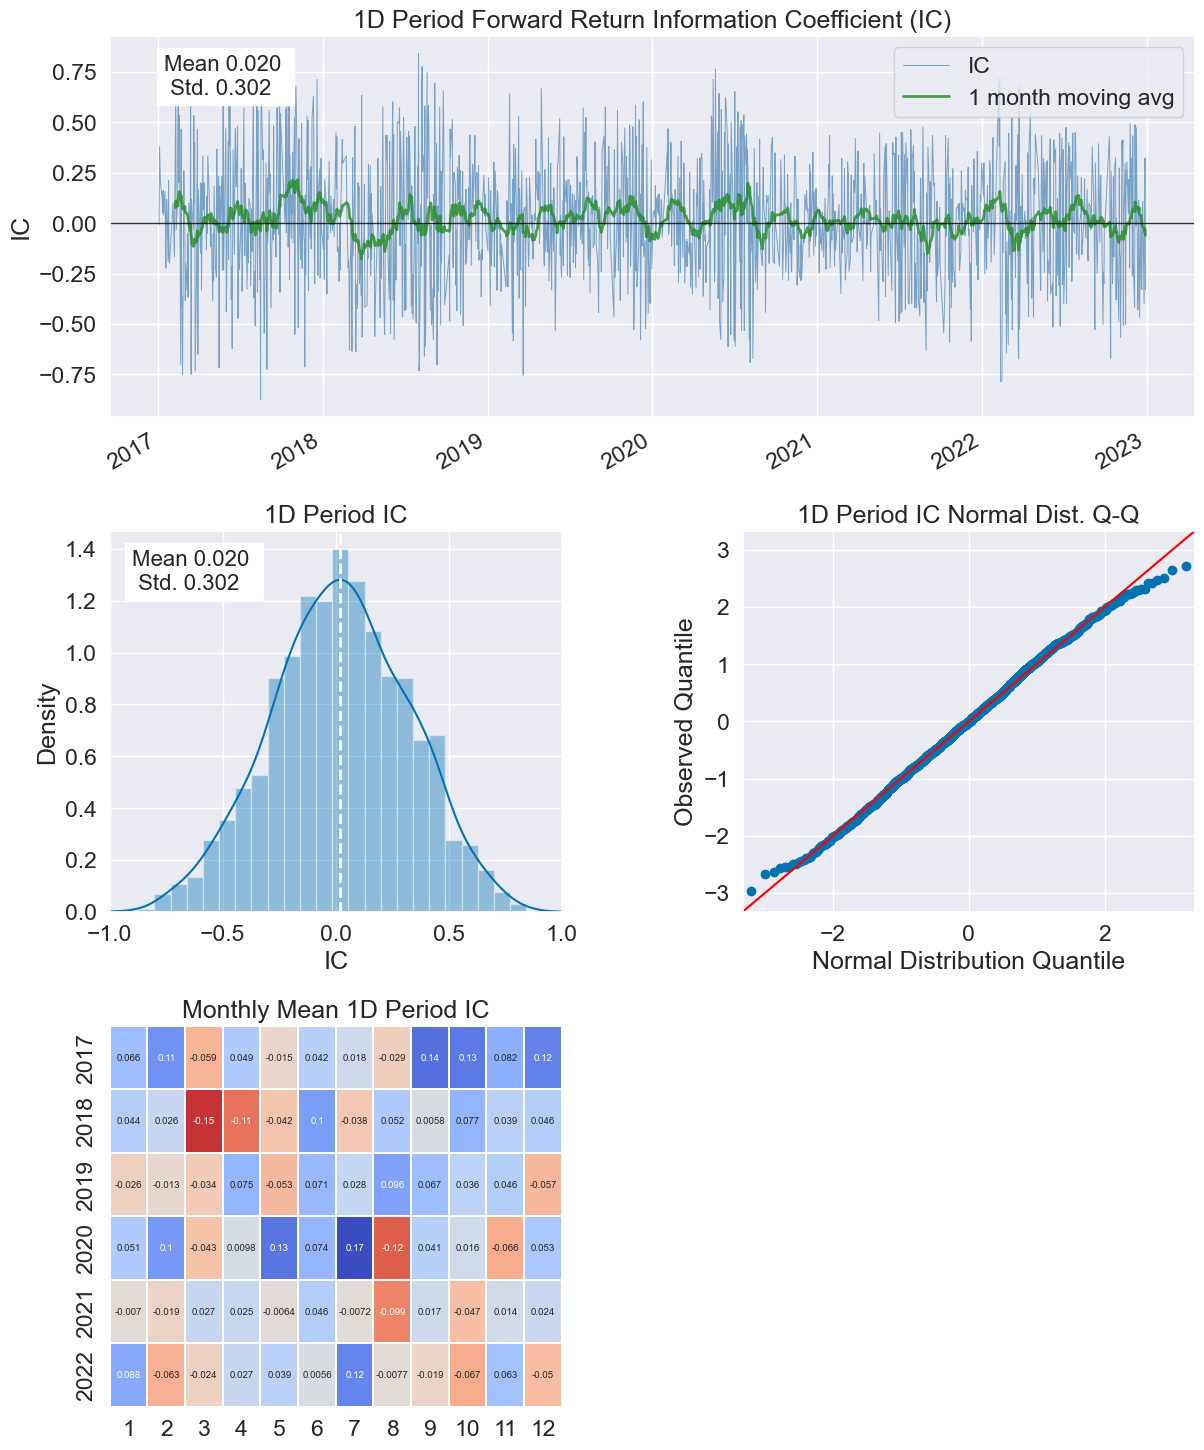

In [ ]:
factor_data3= alphalens.utils.get_clean_factor_and_forward_returns(factor,
                                                                   price_final,
                                                                   groupby=None,
                                                                   binning_by_group=False,
                                                                   #quantiles=[0,0.2,1],
                                                                   quantiles=20,    ###################分层回测
                                                                   bins=None,
                                                                   periods=(1,),          # 持仓周期
                                                                   filter_zscore=5,
                                                                   groupby_labels=None,
                                                                   max_loss=1,               # 能容忍的最大缺省值百分比
                                                                   zero_aware=False,
                                                                   cumulative_returns=True)
alphalens.tears.create_full_tear_sheet(factor_data3,long_short=False,
                           group_neutral=False,
                           by_group=False) 